### Data Preparation

In [1]:
import pandas as pd

# Load the processed data
fraud = pd.read_pickle("../data/processed/fraud_data_processed.pkl")

# Check the first few rows
fraud.head()

# Separate features and target
X = fraud.drop(columns=['class'])
y = fraud['class']

# Verify shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (151112, 15)
Target shape: (151112,)


### Train - Test split 

In [2]:
from sklearn.model_selection import train_test_split

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserves class distribution
)

# Check the distribution in train and test sets
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

Test class distribution:
 class
0    0.906363
1    0.093637
Name: proportion, dtype: float64


### Baseline Logistic Regression.

In [3]:
# Select only numeric columns for modeling
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])
X_test_numeric = X_test.select_dtypes(include=['int64', 'float64'])

print("Train numeric features shape:", X_train_numeric.shape)
print("Test numeric features shape:", X_test_numeric.shape)


Train numeric features shape: (120889, 6)
Test numeric features shape: (30223, 6)


c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


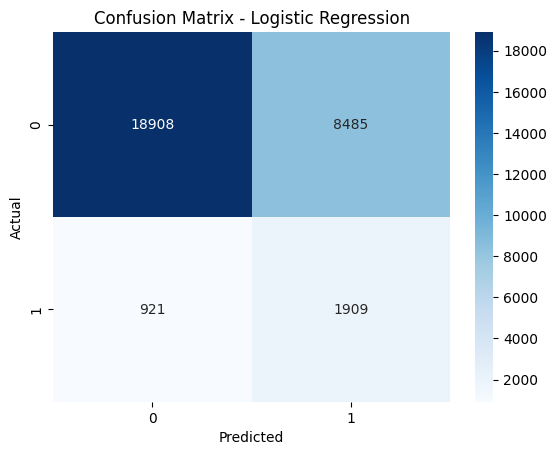

              precision    recall  f1-score   support

           0     0.9536    0.6902    0.8008     27393
           1     0.1837    0.6746    0.2887      2830

    accuracy                         0.6888     30223
   macro avg     0.5686    0.6824    0.5448     30223
weighted avg     0.8815    0.6888    0.7529     30223

PR-AUC: 0.282


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Logistic Regression with balanced class weights
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Train the model
log_reg.fit(X_train_numeric, y_train)

# Predictions
y_pred = log_reg.predict(X_test_numeric)
y_proba = log_reg.predict_proba(X_test_numeric)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

# PR-AUC
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", round(pr_auc, 4))


### Random Forest Modeling

In [6]:
# Select only numeric columns from X_train / X_test
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_num = X_train[numeric_cols]
X_test_num = X_test[numeric_cols]

print("Train numeric features shape:", X_train_num.shape)
print("Test numeric features shape:", X_test_num.shape)


Train numeric features shape: (120889, 6)
Test numeric features shape: (30223, 6)


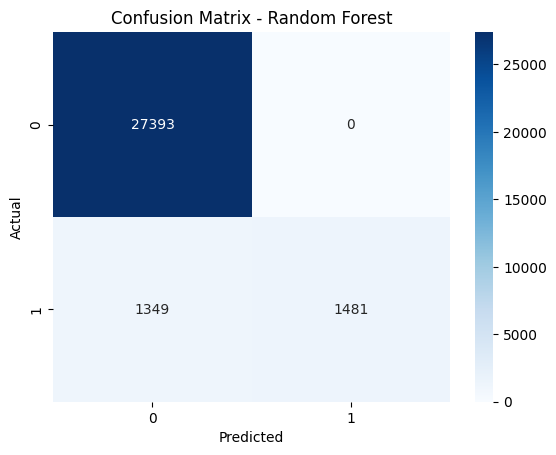

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.52      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

PR-AUC (Random Forest): 0.6098


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_num, y_train)

y_pred_rf = rf.predict(X_test_num)
y_proba_rf = rf.predict_proba(X_test_num)[:,1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_rf))

# PR-AUC
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
print("PR-AUC (Random Forest):", round(pr_auc_rf, 4))


### Tuning

In [22]:
# Select numeric columns only
numeric_cols = X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns
X_train_num = X_train[numeric_cols]
X_test_num = X_test[numeric_cols]

print("Train numeric features shape:", X_train_num.shape)
print("Test numeric features shape:", X_test_num.shape)


Train numeric features shape: (120889, 8)
Test numeric features shape: (30223, 8)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5}
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.52      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

PR-AUC (Random Forest): 0.6145


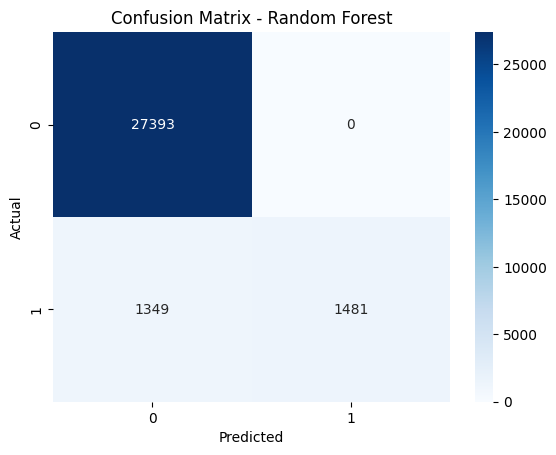

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


rf = RandomForestClassifier(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,           # number of parameter settings sampled
    scoring='average_precision',  # PR-AUC
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train_num, y_train)


best_rf = random_search.best_estimator_
print("Best Random Forest params:", random_search.best_params_)


y_pred = best_rf.predict(X_test_num)
y_proba = best_rf.predict_proba(X_test_num)[:, 1]


print(classification_report(y_test, y_pred))
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC (Random Forest):", round(pr_auc, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


### XGBoost

In [8]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

# -----------------------------
#  Select features
# -----------------------------
numeric_cols = ['purchase_value', 'age', 'ip_address', 'time_since_signup', 'hour_of_day', 'day_of_week', 'ip_int']
categorical_cols = ['device_id', 'source', 'browser', 'sex', 'country']

# Convert categorical columns to category dtype
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Drop datetime columns
X_train = X_train[numeric_cols + categorical_cols]
X_test = X_test[numeric_cols + categorical_cols]


xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True,
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"PR-AUC (XGBoost with categorical): {pr_auc:.4f}")


c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:42:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.94      0.52      0.67      2830

    accuracy                           0.95     30223
   macro avg       0.94      0.76      0.82     30223
weighted avg       0.95      0.95      0.95     30223

PR-AUC (XGBoost with categorical): 0.6041


### Lightweight

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

# Improved training parameters
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,              # no depth limit → prevents "no split" warnings
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "random_state": 42,
    "verbose": -1
}

# Initialize model with ~200 trees (good starting point)
lgb_model = LGBMClassifier(**params, n_estimators=200)

# Train
lgb_model.fit(X_train, y_train)

# Predict
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n LightGBM Classification Report:")
print(classification_report(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"🔍 PR-AUC (LightGBM): {pr_auc:.4f}")

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



 LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.52      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

🔍 PR-AUC (LightGBM): 0.6185

 Confusion Matrix:
[[27393     0]
 [ 1349  1481]]


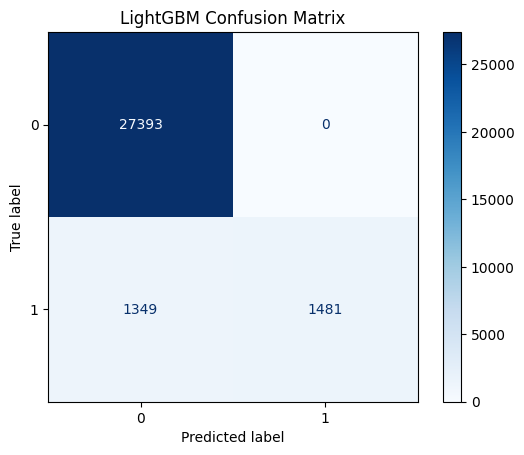

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.savefig("../models/lightgbm_confusion_matrix.png")
plt.show()


In [16]:
import joblib
joblib.dump(lgb_model, "../models/best_model_lightgbm.pkl")
print("Model saved to models folder.")


Model saved to models folder.
